Graph Nodes:
[(1, {'type': 'Activity', 'description': 'A1: Suspicious email reading event through Graph API'}), (2, {'type': 'IoC', 'description': 'A1.IoC1: ClientAppId: bb77fe0b-52af-4f26-9bc7-19aa48854ebf'}), (3, {'type': 'Activity', 'description': 'A2: Check last authentication time of client app'}), (4, {'type': 'IoC', 'description': 'A2.IoC1: Service name: ReadEmailEWS using Graph API'}), (5, {'type': 'IoC', 'description': 'A2.IoC2: IP Address: 72.43.121.44'}), (6, {'type': 'Activity', 'description': 'A3: Credential added to client app ReadEmailEWS'}), (7, {'type': 'Activity', 'description': 'A4: Password spray attack from IP address 72.43.121.44'}), (8, {'type': 'Activity', 'description': 'A5: Client app used to enumerate users and applications with Graph API'})]

Graph Edges:
[(1, 2, {}), (2, 3, {}), (2, 8, {}), (3, 4, {}), (3, 5, {}), (4, 6, {}), (5, 7, {})]


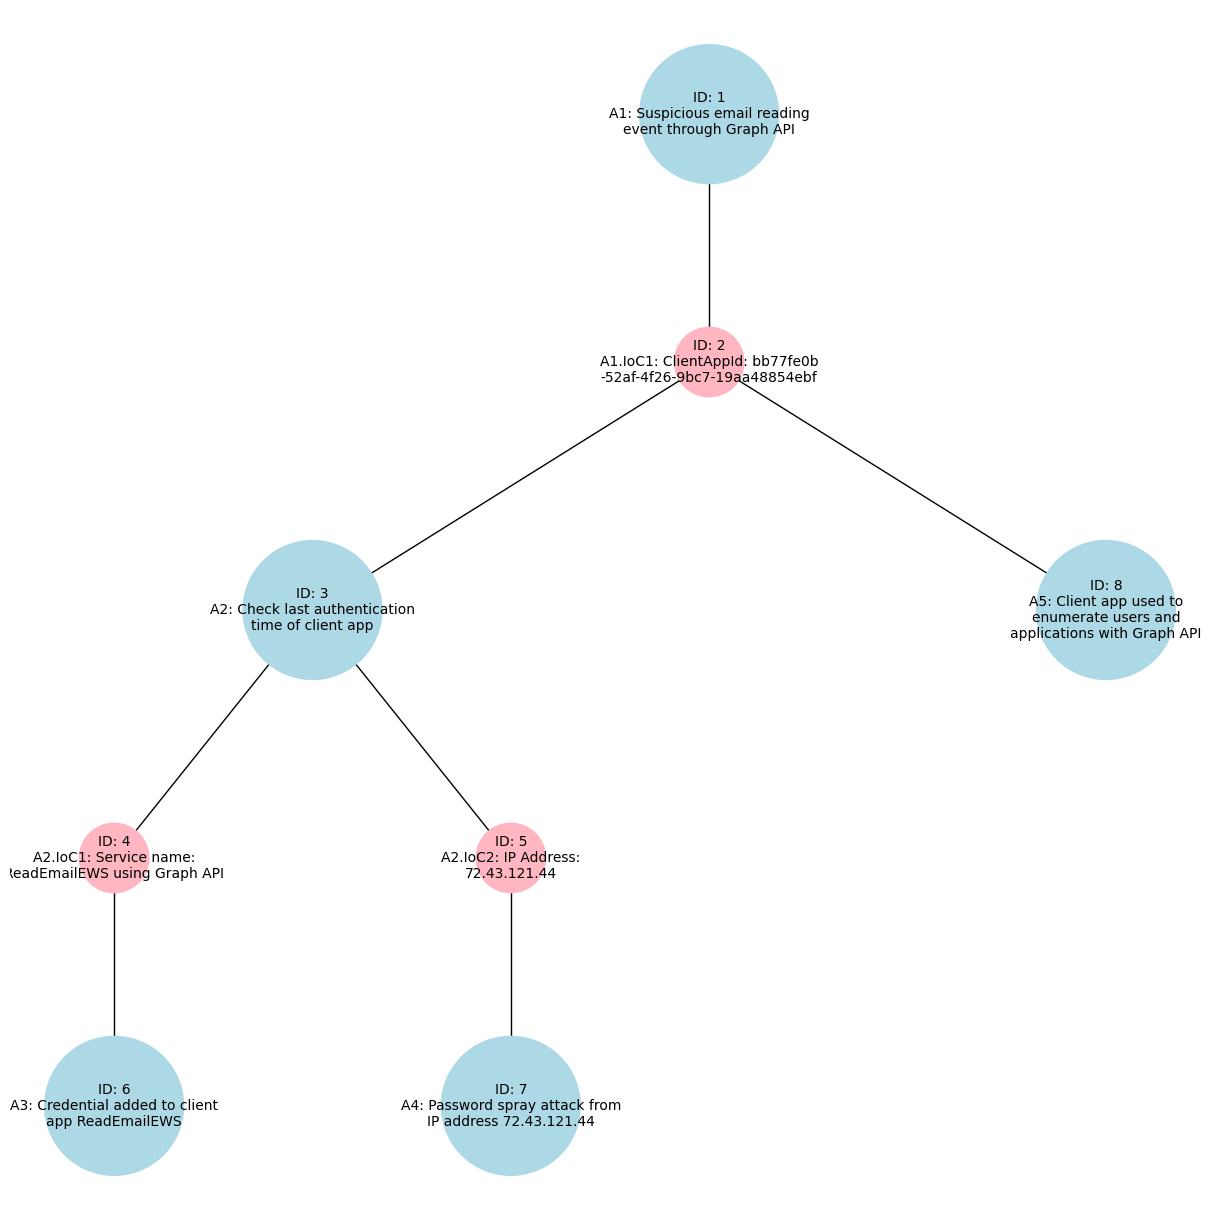

In [39]:
from soc_graph import SOCGraph

# Example Usage
soc_graph = SOCGraph()

# Adding activities and IoCs based on the report
# A1
activity1 = soc_graph.add_activity("A1: Suspicious email reading event through Graph API")
ioc1_a1 = soc_graph.add_ioc("A1.IoC1: ClientAppId: bb77fe0b-52af-4f26-9bc7-19aa48854ebf", from_activity_id=activity1)

# A2
activity2 = soc_graph.add_activity("A2: Check last authentication time of client app", from_ioc_id=ioc1_a1)
ioc1_a2 = soc_graph.add_ioc("A2.IoC1: Service name: ReadEmailEWS using Graph API", from_activity_id=activity2)
ioc2_a2 = soc_graph.add_ioc("A2.IoC2: IP Address: 72.43.121.44", from_activity_id=activity2)

# A3
activity3 = soc_graph.add_activity("A3: Credential added to client app ReadEmailEWS", from_ioc_id=ioc1_a2)

# A4
activity4 = soc_graph.add_activity("A4: Password spray attack from IP address 72.43.121.44", from_ioc_id=ioc2_a2)

# A5
activity5 = soc_graph.add_activity("A5: Client app used to enumerate users and applications with Graph API", from_ioc_id=ioc1_a1)

print("Graph Nodes:")
print(soc_graph.G.nodes(data=True))

print("\nGraph Edges:")
print(soc_graph.G.edges(data=True))

# Plotting the graph with a tree layout starting from activity1
soc_graph.plot_custom_graph(root=activity1, figsize=(12, 12), base_node_size=10000, max_line_length=30)


## A1: There is a suspicious email reading event, where the emails are read with Graph API through a previously unknown application registration.
```kql
OfficeActivity
| where Operation == "MailItemsAccessed" and AppId == "00000003-0000-0000-c000-000000000000"
```

### A1.IoC
1. ClientAppId: bb77fe0b-52af-4f26-9bc7-19aa48854ebf
2. MailboxOwnerUPN: mmelendez@DefenderATEVET17.onmicrosoft.com
   - the user's mailbox who was accessed.


## A2: Table to look up more information about the client app registration:
### A2.IoC 
1. ObjectId: 47dee0a2-d662-4664-acfa-a28bb62bdbc0


## A3: We identify the last time this client app with `ClientAppId` was authenticated.
- From A1.IoC1
```kql
AADServicePrincipalSignInLogs
| where AppId == "bb77fe0b-52af-4f26-9bc7-19aa48854ebf"
```

### A3.IoC 
1. IPAddress: 72.43.121.43
    - From the above query, we identify a new IOC: The IPAdress where the service principal authenticated from is found 72.43.121.43


## A4: Other authentication events from the same IP address.
- From A3.IoC1
```kql
let ipAddress = "72.43.121.43";
SigninLogs
    | where IPAddress == ipAddress
    | project TimeGenerated, IPAddress, UserPrincipalName, ResultType, ResultDescription, AuthenticationRequirement, ConditionalAccessStatus,  ResourceDisplayName, AppDisplayName, ResourceIdentity, ClientAppUsed, RiskLevelAggregated, RiskLevelDuringSignIn, RiskState, RiskEventTypes
```
### A4.IoC
- Multiple users are authenticating from the same IP address but failed. There is one account that successfully authenticated from this account: mvelazco@defender...


## A5: We search for the latest actions that have occurred to this application registration: modifications, updates, etc.
- From A2.IoC1

```kql
AuditLogs
| mv-expand TargetResource = TargetResources
| extend TargetResourceJson = parse_json(TargetResource)
| where TargetResourceJson.id == "47dee0a2-d662-4664-acfa-a28bb62bdbc0"
```

### IoC
- We learn that there were certain changes made against the application. Specifically, new credentials were added to the application registration right before it authenticated



## A6: We search for other graph activities with the same IP address: 72.43.121.43
- From A3.IoC1
```kql
MicrosoftGraphActivityLogs
| where RequestUri endswith "/users" or RequestUri endswith "/applications"  
| where  IPAddress == "72.43.121.43"
```

### A6.IoC
- We find that the same IP address is making requests to the Microsoft Graph API for both users and applications. 




In [ ]:
report = [
    {
        'id': 1,
        'type': 'investigation',
        'title': 'Check table `OfficeActivity` with Graph API\'s id for mail read events.',

        'table': 'OfficeActivity',
        'kql': 'OfficeActivity | where Operation == "MailItemsAccessed" and AppId == "00000003-0000-0000-c000-000000000000"',
        'sql': 'SELECT * FROM OfficeActivity WHERE Operation = "MailItemsAccessed" AND AppId = "00000003-0000-0000-c000-000000000000"',
    },

    {
        'id': 2,
        'type': 'IoC',
        'key': 'ClientAppId',
        'value': 'bb77fe0b-52af-4f26-9bc7-19aa48854ebf',
        'from_investigation': [1],
    },

    {
        'id': 3,
        'type': 'IoC',
        'key': 'MailboxOwnerUPN',
        'value': "mmelendez@DefenderATEVET17.onmicrosoft.com",
        'from_investigation': [1],
    },

    {
        'id': 4,
        'type': 'investigation',
        'title': 'Check table `SecurityExposureManagement` to find more information about the client app with that ID.',
        'from_iocs': [2],
    },

    {
        'id': 5,
        'type': 'IoC',
        'key': 'ObjectId',
        'value': '47dee0a2-d662-4664-acfa-a28bb62bdbc0',
        'from_investigation': [4],
    },

    {
        'id': 6,
        'type': 'investigation',
        'title': 'Check `AADServicePrincipalSignInLogs` to identify the last time this client app with `ClientAppId` was authenticated.',
        'kql': 'AADServicePrincipalSignInLogs | where AppId == "bb77fe0b-52af-4f26-9bc7-19aa48854ebf"',
        'sql': 'SELECT * FROM AADServicePrincipalSignInLogs WHERE AppId = "bb77fe0b-52af-4f26-9bc7-19aa48854ebf"',
        'from_iocs': [2],
    },

    {
        'id': 7,
        'type': 'IoC',
        'key': 'IPAddress',
        'value': '72.43.121.34',
        'from_investigation': [6],
    },

    {
        'id': 8,
        'type': 'investigation',
        'title': 'Check `SigninLogs` for other authentication events from the same IP address.',
        'kql': """let ipAddress = "72.43.121.43";
SigninLogs
    | where IPAddress == ipAddress
    | project TimeGenerated, IPAddress, UserPrincipalName, ResultType, ResultDescription, AuthenticationRequirement, ConditionalAccessStatus,  ResourceDisplayName, AppDisplayName, ResourceIdentity, ClientAppUsed, RiskLevelAggregated, RiskLevelDuringSignIn, RiskState, RiskEventTypes
""" ,   
        'sql': """SELECT TimeGenerated, IPAddress, UserPrincipalName, ResultType, ResultDescription, AuthenticationRequirement, ConditionalAccessStatus,  ResourceDisplayName, AppDisplayName, ResourceIdentity, ClientAppUsed, RiskLevelAggregated, RiskLevelDuringSignIn, RiskState, RiskEventTypes
FROM SigninLogs
WHERE IPAddress = '72.43.121.43'""",

        'from_iocs': [7],
    },
    
]


Graph Nodes:
[(1, {'type': 'Activity', 'description': 'There is a suspicious email reading event, where the emails are read with Graph API through a previously unknown application registration.'}), (2, {'type': 'IoC', 'description': 'ClientAppId: bb77fe0b-52af-4f26-9bc7-19aa48854ebf'}), (3, {'type': 'IoC', 'description': 'MailboxOwnerUPN: mmelendez@DefenderATEVET17.onmicrosoft.com'}), (4, {'type': 'Activity', 'description': 'Check table `SecurityExposureManagement` to find more information about the client app with that ID.'}), (5, {'type': 'IoC', 'description': 'ObjectId: 47dee0a2-d662-4664-acfa-a28bb62bdbc0'}), (6, {'type': 'Activity', 'description': 'Check `AADServicePrincipalSignInLogs` to identify the last time this client app with `ClientAppId` was authenticated.'}), (7, {'type': 'IoC', 'description': 'IPAddress: 72.43.121.34'}), (8, {'type': 'Activity', 'description': 'Check `SigninLogs` for other authentication events from the same IP address.'}), (9, {'type': 'IoC', 'descripti

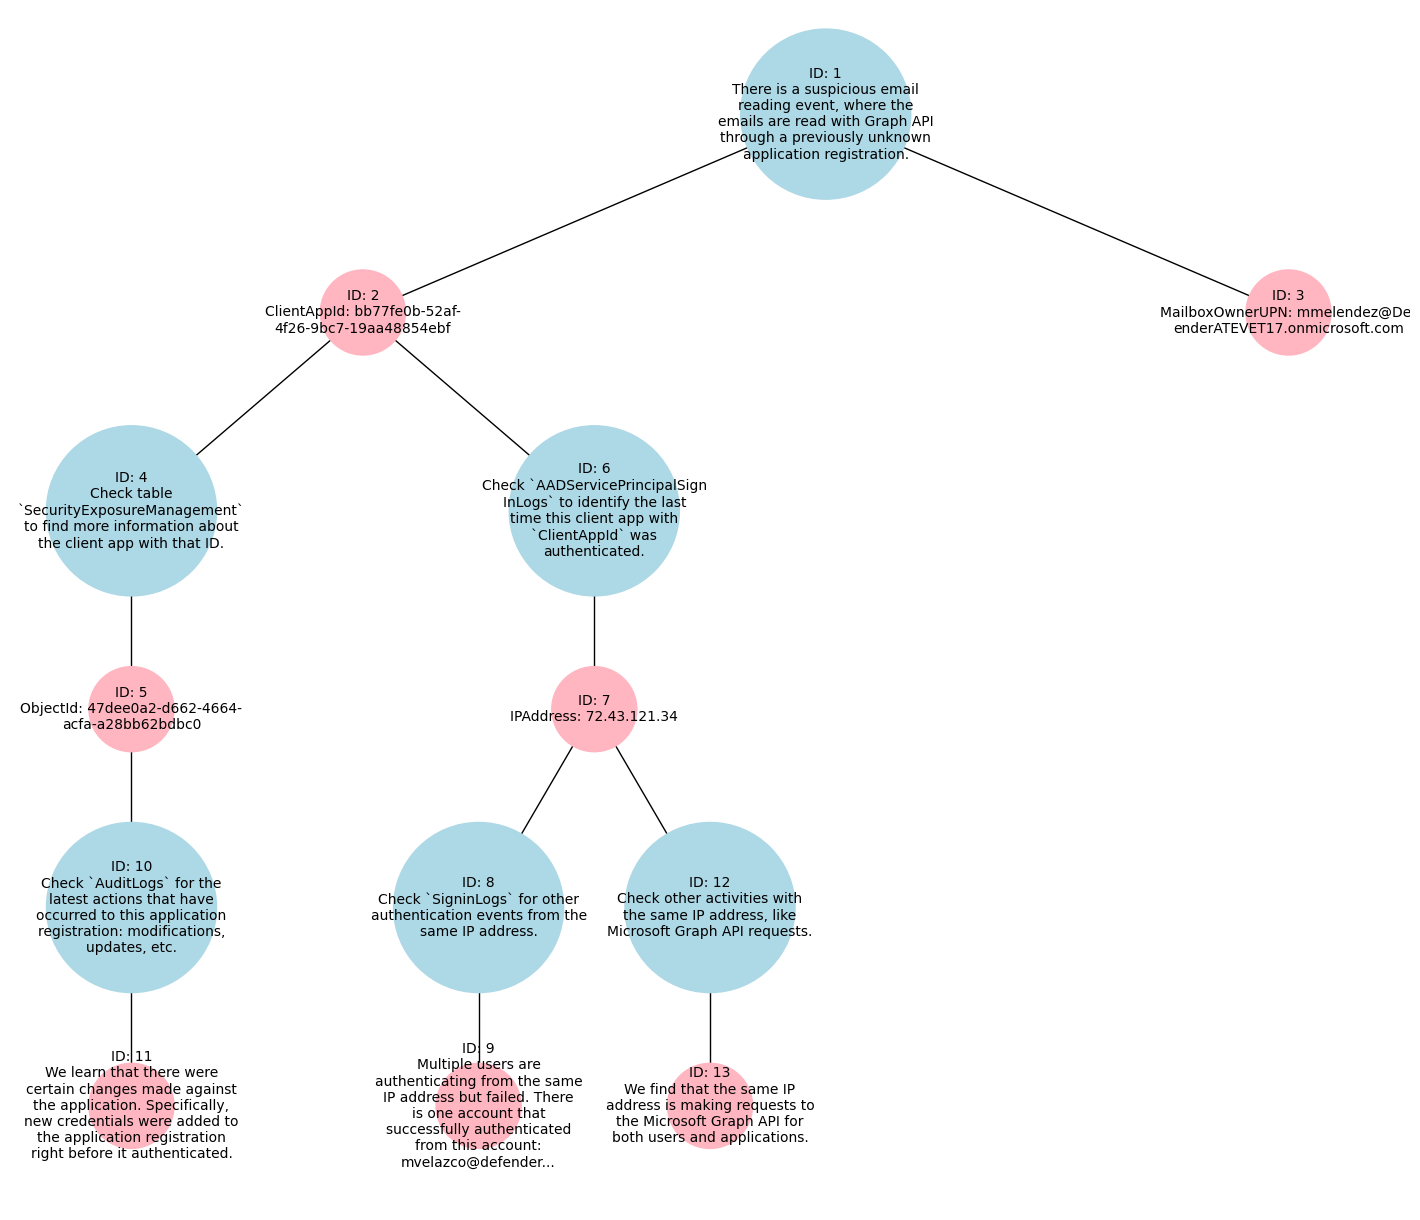

In [1]:
from soc_graph import SOCGraph



report = """
Given: There is a suspicious email reading event, where the emails are read with Graph API through a previously unknown application registration.

----------------------------------------------------------------------------------------------------------------------------
## Investigation 1: Check table `OfficeActivity` with Graph API's id for mail read events.
```kql
OfficeActivity
| where Operation == "MailItemsAccessed" and AppId == "00000003-0000-0000-c000-000000000000"
```
```sql
SELECT *
FROM OfficeActivity
WHERE Operation = 'MailItemsAccessed' AND AppId = '00000003-0000-0000-c000-000000000000'
```

### I1.IoC
1. ClientAppId: bb77fe0b-52af-4f26-9bc7-19aa48854ebf
2. MailboxOwnerUPN: mmelendez@DefenderATEVET17.onmicrosoft.com
   - the user's mailbox who was accessed.

----------------------------------------------------------------------------------------------------------------------------
## Investigation 2: Check table `SecurityExposureManagement` to find more information about the client app with that ID.
### I2.IoC 
1. ObjectId: 47dee0a2-d662-4664-acfa-a28bb62bdbc0

----------------------------------------------------------------------------------------------------------------------------
## Investigation 3: Check `AADServicePrincipalSignInLogs` to identify the last time this client app with `ClientAppId` was authenticated.
- From I1.IoC1
```kql
AADServicePrincipalSignInLogs
| where AppId == "bb77fe0b-52af-4f26-9bc7-19aa48854ebf"
```

### I3.IoC
1. IPAddress: 72.43.121.34
    - From the above query, we identify a new IOC: The IPAdress where the service principal authenticated from is found 72.43.121.34

----------------------------------------------------------------------------------------------------------------------------
## Investigation 4: Check `SigninLogs` for other authentication events from the same IP address.
- From A3.IoC1
```kql
let ipAddress = "72.43.121.43";
SigninLogs
    | where IPAddress == ipAddress
    | project TimeGenerated, IPAddress, UserPrincipalName, ResultType, ResultDescription, AuthenticationRequirement, ConditionalAccessStatus,  ResourceDisplayName, AppDisplayName, ResourceIdentity, ClientAppUsed, RiskLevelAggregated, RiskLevelDuringSignIn, RiskState, RiskEventTypes
```
### I4.IoC
- Multiple users are authenticating from the same IP address but failed. There is one account that successfully authenticated from this account: mvelazco@defender...

----------------------------------------------------------------------------------------------------------------------------
## Investigation 5: Check `AuditLogs` for the latest actions that have occurred to this application registration: modifications, updates, etc.
- From I2.IoC1

```kql
AuditLogs
| mv-expand TargetResource = TargetResources
| extend TargetResourceJson = parse_json(TargetResource)
| where TargetResourceJson.id == "47dee0a2-d662-4664-acfa-a28bb62bdbc0"
```

### IoC
- We learn that there were certain changes made against the application. Specifically, new credentials were added to the application registration right before it authenticated.

----------------------------------------------------------------------------------------------------------------------------
## Investigation 6: We check other activities with the same IP address, like Microsoft Graph API requests.
- From I3.IoC1
```kql
MicrosoftGraphActivityLogs
| where RequestUri endswith "/users" or RequestUri endswith "/applications"  
| where  IPAddress == "72.43.121.43"
```

### I6.IoC
- We find that the same IP address is making requests to the Microsoft Graph API for both users and applications. 
"""
# Example Usage
soc_graph = SOCGraph()


activity1 = soc_graph.add_activity("There is a suspicious email reading event, where the emails are read with Graph API through a previously unknown application registration.")
ioc1_a1 = soc_graph.add_ioc("ClientAppId: bb77fe0b-52af-4f26-9bc7-19aa48854ebf", from_activity_id=activity1)
ioc2_a1 = soc_graph.add_ioc("MailboxOwnerUPN: mmelendez@DefenderATEVET17.onmicrosoft.com", from_activity_id=activity1)

# activity2
activity2 = soc_graph.add_activity("Check table `SecurityExposureManagement` to find more information about the client app with that ID.", from_ioc_id=ioc1_a1)
ioc1_a2 = soc_graph.add_ioc("ObjectId: 47dee0a2-d662-4664-acfa-a28bb62bdbc0", from_activity_id=activity2)

# activity3
activity3 = soc_graph.add_activity("Check `AADServicePrincipalSignInLogs` to identify the last time this client app with `ClientAppId` was authenticated.", from_ioc_id=ioc1_a1)
ioc1_a3 = soc_graph.add_ioc("IPAddress: 72.43.121.34", from_activity_id=activity3)

# activity4
activity4 = soc_graph.add_activity("Check `SigninLogs` for other authentication events from the same IP address.", from_ioc_id=ioc1_a3)
ioc1_a4 = soc_graph.add_ioc("Multiple users are authenticating from the same IP address but failed. There is one account that successfully authenticated from this account: mvelazco@defender...", from_activity_id=activity4)

# activity5
activity5 = soc_graph.add_activity("Check `AuditLogs` for the latest actions that have occurred to this application registration: modifications, updates, etc.", from_ioc_id=ioc1_a2)
ioc1_a5 = soc_graph.add_ioc("We learn that there were certain changes made against the application. Specifically, new credentials were added to the application registration right before it authenticated.", from_activity_id=activity5)

# activity6
activity6 = soc_graph.add_activity("Check other activities with the same IP address, like Microsoft Graph API requests.", from_ioc_id=ioc1_a3)
ioc1_a6 = soc_graph.add_ioc("We find that the same IP address is making requests to the Microsoft Graph API for both users and applications.", from_activity_id=activity6)


print("Graph Nodes:")
print(soc_graph.G.nodes(data=True))

print("\nGraph Edges:")
print(soc_graph.G.edges(data=True))

# Plotting the graph with a tree layout starting from activity1
soc_graph.plot_custom_graph(root=activity1, figsize=(14, 12), base_node_size=15000, max_line_length=30)



Graph Nodes:
[(1, {'type': 'Investigation', 'description': "Check table `OfficeActivity` with Graph API's id for mail read events."}), (2, {'type': 'IoC', 'description': 'ClientAppId: bb77fe0b-52af-4f26-9bc7-19aa48854ebf'}), (3, {'type': 'IoC', 'description': 'MailboxOwnerUPN: mmelendez@DefenderATEVET17.onmicrosoft.com'}), (4, {'type': 'Investigation', 'description': 'Check table `SecurityExposureManagement` to find more information about the client app with that ID.'}), (5, {'type': 'IoC', 'description': 'ObjectId: 47dee0a2-d662-4664-acfa-a28bb62bdbc0'}), (6, {'type': 'Investigation', 'description': 'Check `AADServicePrincipalSignInLogs` to identify the last time this client app with `ClientAppId` was authenticated.'}), (7, {'type': 'IoC', 'description': 'IPAddress: 72.43.121.34'}), (8, {'type': 'Investigation', 'description': 'Check `SigninLogs` for other authentication events from the same IP address.'}), (9, {'type': 'IoC', 'description': 'Multiple users are authenticating from the

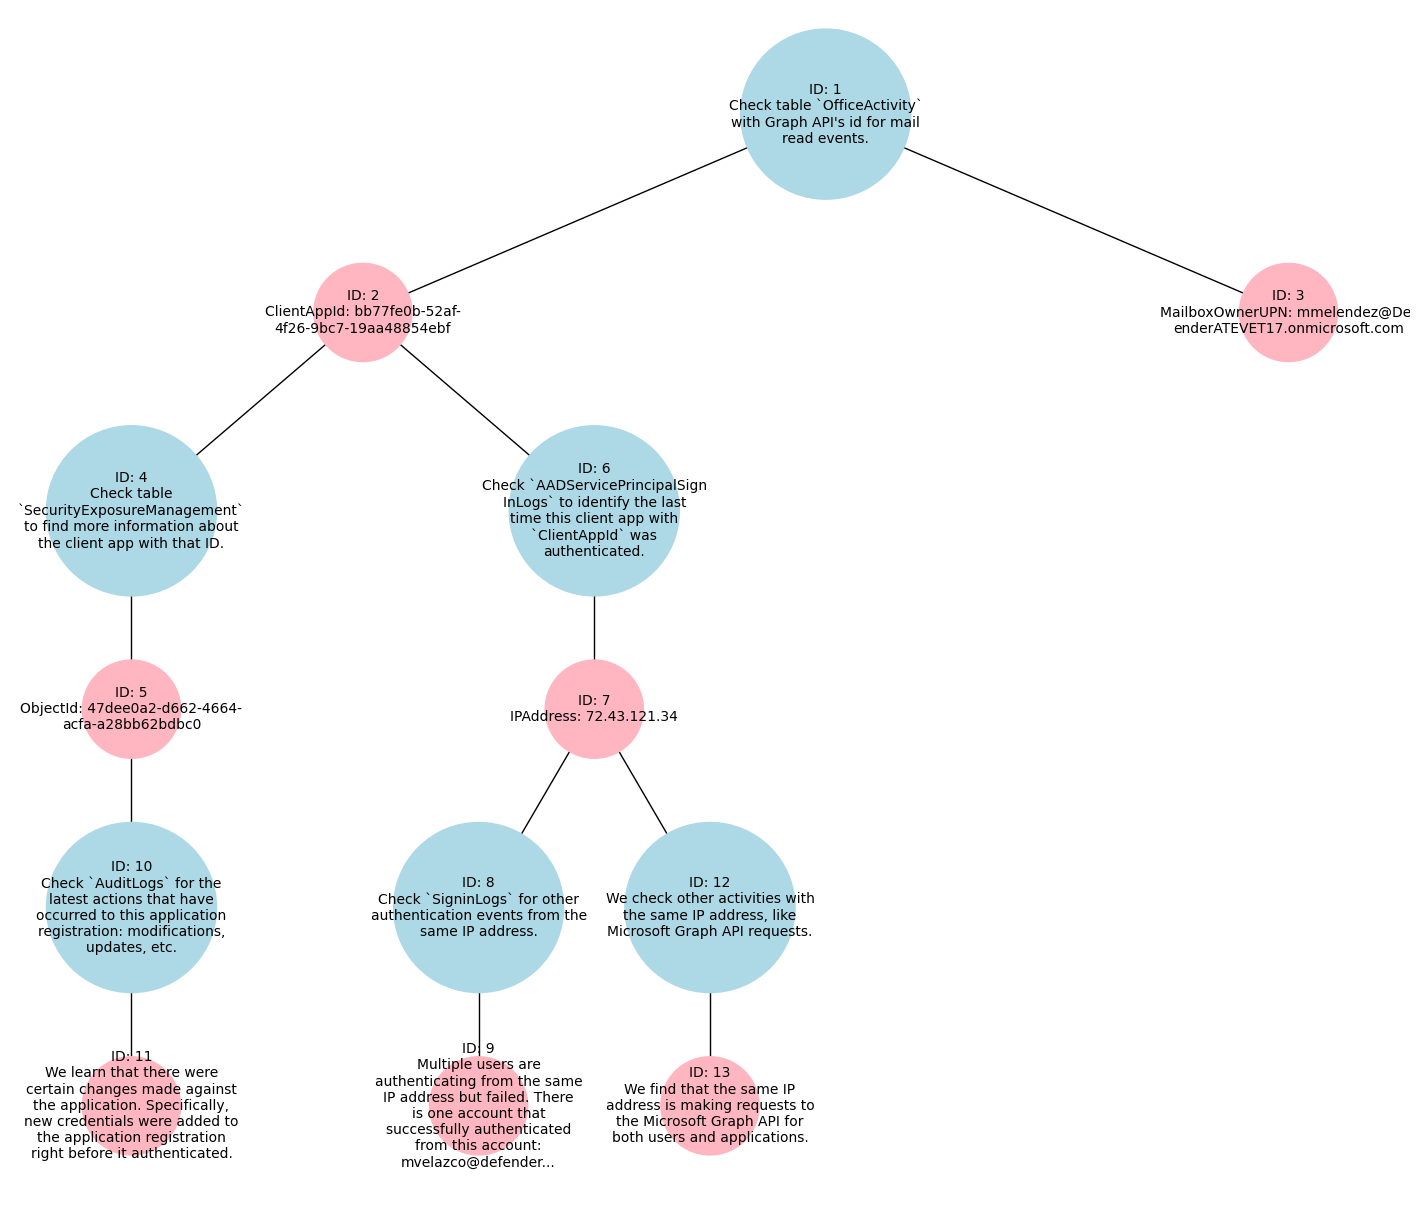

In [2]:
a = [
    {
        "id": 1,
        "type": "investigation",
        "content": "Check table `OfficeActivity` with Graph API's id for mail read events.",
        "table": "OfficeActivity",
        "kql": "OfficeActivity | where Operation == \"MailItemsAccessed\" and AppId == \"00000003-0000-0000-c000-000000000000\"",
        "sql": "SELECT * FROM OfficeActivity WHERE Operation = 'MailItemsAccessed' AND AppId = '00000003-0000-0000-c000-000000000000'",
        "connected": [2, 3]
    },
    {
        "id": 2,
        "type": "IoC",
        "content": "ClientAppId: bb77fe0b-52af-4f26-9bc7-19aa48854ebf",
        "connected": [1, 4, 7]
    },
    {
        "id": 3,
        "type": "IoC",
        "content": "MailboxOwnerUPN: mmelendez@DefenderATEVET17.onmicrosoft.com",
        "connected": [1]
    },
    {
        "id": 4,
        "type": "investigation",
        "content": "Check table `SecurityExposureManagement` to find more information about the client app with that ID.",
        "table": "SecurityExposureManagement",
        "connected": [2, 5]
    },
    {
        "id": 5,
        "type": "IoC",
        "content": "ObjectId: 47dee0a2-d662-4664-acfa-a28bb62bdbc0",
        "connected": [4, 9]
    },
    {
        "id": 6,
        "type": "investigation",
        "content": "Check `AADServicePrincipalSignInLogs` to identify the last time this client app with `ClientAppId` was authenticated.",
        "table": "AADServicePrincipalSignInLogs",
        "kql": "AADServicePrincipalSignInLogs | where AppId == \"bb77fe0b-52af-4f26-9bc7-19aa48854ebf\"",
        "connected": [2, 7]
    },
    {
        "id": 7,
        "type": "IoC",
        "content": "IPAddress: 72.43.121.34",
        "connected": [6, 8, 10]
    },
    {
        "id": 8,
        "type": "investigation",
        "content": "Check `SigninLogs` for other authentication events from the same IP address.",
        "table": "SigninLogs",
        "kql": "let ipAddress = \"72.43.121.43\"; SigninLogs | where IPAddress == ipAddress | project TimeGenerated, IPAddress, UserPrincipalName, ResultType, ResultDescription, AuthenticationRequirement, ConditionalAccessStatus, ResourceDisplayName, AppDisplayName, ResourceIdentity, ClientAppUsed, RiskLevelAggregated, RiskLevelDuringSignIn, RiskState, RiskEventTypes",
        "connected": [7, 9]
    },
    {
        "id": 9,
        "type": "IoC",
        "content": "Multiple users are authenticating from the same IP address but failed. There is one account that successfully authenticated from this account: mvelazco@defender...",
        "connected": [5, 8]
    },
    {
        "id": 10,
        "type": "investigation",
        "content": "Check `AuditLogs` for the latest actions that have occurred to this application registration: modifications, updates, etc.",
        "table": "AuditLogs",
        "kql": "AuditLogs | mv-expand TargetResource = TargetResources | extend TargetResourceJson = parse_json(TargetResource) | where TargetResourceJson.id == \"47dee0a2-d662-4664-acfa-a28bb62bdbc0\"",
        "connected": [5, 7, 11]
    },
    {
        "id": 11,
        "type": "IoC",
        "content": "We learn that there were certain changes made against the application. Specifically, new credentials were added to the application registration right before it authenticated.",
        "connected": [10]
    },
    {
        "id": 12,
        "type": "investigation",
        "content": "We check other activities with the same IP address, like Microsoft Graph API requests.",
        "table": "MicrosoftGraphActivityLogs",
        "kql": "MicrosoftGraphActivityLogs | where RequestUri endswith \"/users\" or RequestUri endswith \"/applications\" | where IPAddress == \"72.43.121.43\"",
        "connected": [7, 13]
    },
    {
        "id": 13,
        "type": "IoC",
        "content": "We find that the same IP address is making requests to the Microsoft Graph API for both users and applications.",
        "connected": [12]
    }
]


from soc_graph import SOCGraph 
soc_graph = SOCGraph()

# investigation1
investigation1 = soc_graph.add_investigation("Check table `OfficeActivity` with Graph API's id for mail read events.")
ioc1_i1 = soc_graph.add_ioc("ClientAppId: bb77fe0b-52af-4f26-9bc7-19aa48854ebf", from_investigation_id=investigation1)
ioc2_i1 = soc_graph.add_ioc("MailboxOwnerUPN: mmelendez@DefenderATEVET17.onmicrosoft.com", from_investigation_id=investigation1)

# investigation2
investigation2 = soc_graph.add_investigation("Check table `SecurityExposureManagement` to find more information about the client app with that ID.", from_ioc_id=ioc1_i1)
ioc1_i2 = soc_graph.add_ioc("ObjectId: 47dee0a2-d662-4664-acfa-a28bb62bdbc0", from_investigation_id=investigation2)

# investigation3
investigation3 = soc_graph.add_investigation("Check `AADServicePrincipalSignInLogs` to identify the last time this client app with `ClientAppId` was authenticated.", from_ioc_id=ioc1_i1)
ioc1_i3 = soc_graph.add_ioc("IPAddress: 72.43.121.34", from_investigation_id=investigation3)

# investigation4
investigation4 = soc_graph.add_investigation("Check `SigninLogs` for other authentication events from the same IP address.", from_ioc_id=ioc1_i3)
ioc1_i4 = soc_graph.add_ioc("Multiple users are authenticating from the same IP address but failed. There is one account that successfully authenticated from this account: mvelazco@defender...", from_investigation_id=investigation4)

# investigation5
investigation5 = soc_graph.add_investigation("Check `AuditLogs` for the latest actions that have occurred to this application registration: modifications, updates, etc.", from_ioc_id=ioc1_i2)
ioc1_i5 = soc_graph.add_ioc("We learn that there were certain changes made against the application. Specifically, new credentials were added to the application registration right before it authenticated.", from_investigation_id=investigation5)

# investigation6
investigation6 = soc_graph.add_investigation("We check other activities with the same IP address, like Microsoft Graph API requests.", from_ioc_id=ioc1_i3)
ioc1_i6 = soc_graph.add_ioc("We find that the same IP address is making requests to the Microsoft Graph API for both users and applications.", from_investigation_id=investigation6)


print("Graph Nodes:")
print(soc_graph.G.nodes(data=True))

print("\nGraph Edges:")
print(soc_graph.G.edges(data=True))

# Plotting the graph with a tree layout starting from activity1
soc_graph.plot_custom_graph(root=investigation1, figsize=(14, 12), base_node_size=15000, max_line_length=30)
